<a href="https://colab.research.google.com/github/leihuang/scrapbook/blob/master/DANN_Moons.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [77]:
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

print(sys.version)

3.7.12 (default, Jan 15 2022, 18:48:18) 
[GCC 7.5.0]


In [78]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [79]:
!ls -l /content/drive/MyDrive/Research

total 4
drwx------ 10 root root 4096 Mar  5 23:59 transferlearning


In [35]:
# !git clone https://github.com/jindongwang/transferlearning.git /content/drive/MyDrive/Research/transferlearning/

Cloning into '/content/drive/MyDrive/Research/transferlearning'...
remote: Enumerating objects: 6415, done.
remote: Counting objects: 100% (2939/2939), done.
remote: Compressing objects: 100% (1804/1804), done.
remote: Total 6415 (delta 1183), reused 2740 (delta 1077), pack-reused 3476
Receiving objects: 100% (6415/6415), 35.69 MiB | 5.35 MiB/s, done.
Resolving deltas: 100% (3429/3429), done.
Checking out files: 100% (352/352), done.


In [80]:
from sklearn.datasets import make_moons

In [102]:
X, y = make_moons(n_samples=100, noise=0.1, random_state=42)

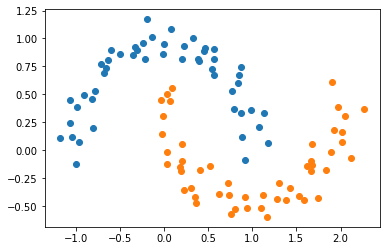

In [92]:
fig, ax = plt.subplots()
ax.scatter(*X[y==0].T)
ax.scatter(*X[y==1].T)
plt.show()

In [107]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import tqdm


class Model0(nn.Module):
    def __init__(self, width):
        super(Model0, self).__init__()
        self.layer1 = nn.Linear(2, width)
        self.layer2 = nn.Linear(width, 2)
        self.layer3 = nn.Linear(2, 1)
        
    def forward(self, x):
        #x = xd[:,:2]
        x = torch.tanh(self.layer1(x))
        x = torch.tanh(self.layer2(x))
        p = torch.sigmoid(self.layer3(x))[:,0]
        return p


def train_and_validate(model, optimizer, loss_fn, X_train, y_train, X_test, y_test, nepoch):
    """
    """
    losss = []
    accus = []
    ps = []

    for epoch in tqdm.trange(nepoch):
        y_pred = model(X_train)
        loss = loss_fn(y_pred, y_train)
        losss.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            y_pred = model(X_test)
            bools = ((y_pred>0.5).long() == y_test).type(torch.FloatTensor)
            accus.append(bools.mean())

    return np.array(losss), np.array(accus)



model0 = Model0(5)
optimizer0 = torch.optim.Adam(model0.parameters(), lr=0.01)
loss_fn = nn.BCELoss()


In [108]:
X_ = Variable(torch.from_numpy(X)).float()
y_ = Variable(torch.from_numpy(y)).float()

losss, accus = train_and_validate(model0, optimizer0, loss_fn, X_, y_, X_, y_, 500)

100%|██████████| 500/500 [00:00<00:00, 1189.20it/s]


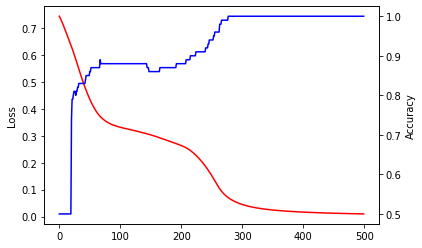

In [109]:
fig, ax = plt.subplots()
ax.plot(losss, color='r')
ax.set_ylabel('Loss')
ax2 = ax.twinx()
ax2.plot(accus, color='b')
ax2.set_ylabel('Accuracy')
plt.show()

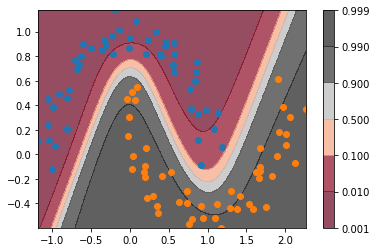

In [146]:
k = 100
x1s = np.linspace(X[:,0].min(), X[:,0].max(), k)
x2s = np.linspace(X[:,1].min(), X[:,1].max(), k)

x1ss, x2ss = np.meshgrid(x1s, x2s)
Xp = np.array(list(zip(x1ss.flatten(), x2ss.flatten())))
Xp_ = Variable(torch.from_numpy(Xp)).float()
zss = model0.forward(Xp_).detach().numpy().reshape(k, k)

fig, ax = plt.subplots()
contours = plt.contourf(x1ss, x2ss, zss, [0.001,0.01, 0.1, 0.5, 0.9, 0.99,0.999], cmap='RdGy', alpha=0.7)
# plt.clabel(contours, inline=True, fontsize=12)
plt.colorbar()

ax.scatter(*X[y==0].T)
ax.scatter(*X[y==1].T)

plt.show()

In [118]:
plt.contour?